In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import skew, kurtosis

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

Code below is based on 

- https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Graph_TimeSeries_Forecasting/Graph_TimeSeries_Forecasting.ipynb
- the above comes from https://towardsdatascience.com/time-series-forecasting-with-graph-convolutional-neural-network-7ffb3b70afcf
- https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gat.py

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

In [5]:
from spektral_utilities import *
from spektral_gcn import GraphConv

from spektral.layers import GCNConv


In [6]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 24 # play with this

def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, 10, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, 10))

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


In [7]:
### READ DATA ###

df = pd.read_csv('../dataset/SalesGNNTimeSeries/sales_train.csv.zip')
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
### SWITCH DATA FROM VERTICAL TO HORIZONTAL FORMAT ###

unstaked_df = df.copy()
unstaked_df['id'] = df['item'].astype(str)+'_'+df['store'].astype(str)
unstaked_df.set_index(['id','date'], inplace=True)
unstaked_df.drop(['store','item'], axis=1, inplace=True)
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

print(unstaked_df.shape)
unstaked_df.head()

(500, 1826)


date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
id,,,,,,,,,,,,,,,,,,,,,
10_1,37.0,34.0,32.0,45.0,35.0,54.0,37.0,37.0,32.0,36.0,...,60.0,67.0,88.0,42.0,50.0,55.0,63.0,56.0,78.0,74.0
10_10,45.0,50.0,53.0,51.0,54.0,54.0,54.0,40.0,50.0,53.0,...,64.0,74.0,66.0,61.0,53.0,72.0,81.0,69.0,86.0,67.0
10_2,51.0,56.0,46.0,56.0,53.0,68.0,37.0,47.0,65.0,61.0,...,86.0,114.0,84.0,66.0,69.0,63.0,78.0,76.0,77.0,116.0
10_3,38.0,60.0,50.0,46.0,46.0,52.0,40.0,41.0,32.0,38.0,...,83.0,71.0,101.0,45.0,61.0,51.0,56.0,61.0,72.0,68.0
10_4,30.0,29.0,37.0,45.0,52.0,58.0,29.0,44.0,53.0,39.0,...,75.0,64.0,86.0,56.0,54.0,57.0,53.0,65.0,74.0,69.0


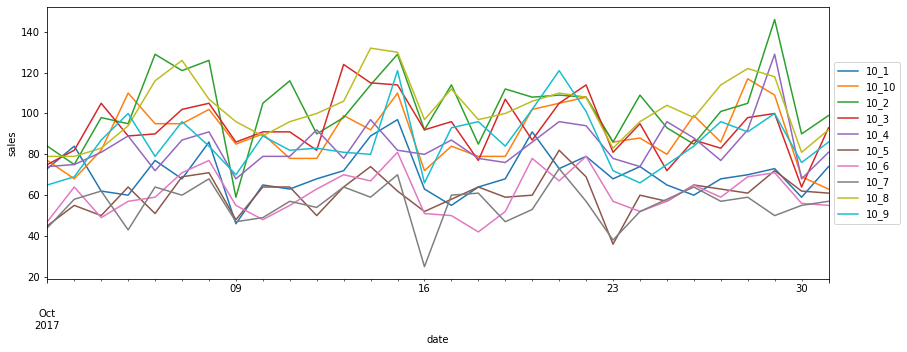

In [7]:
### PLOT A SEQUENCE OF SALES FOR ITEM 10 IN ALL STORES ###

sequence = get_timespan(unstaked_df, date(2017,11,1), 30)
sequence.head(10).T.plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [9]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = date(2013, 1, 1)
valid_date = date(2015, 1, 1)
test_date = date(2016, 1, 1)

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:27<00:00, 25.44it/s]


(35350, 24, 10) (35350, 10, 10) (35350, 10, 7) (35350, 10)


In [10]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:11<00:00, 29.59it/s]


(17100, 24, 10) (17100, 10, 10) (17100, 10, 7) (17100, 10)


In [11]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), date(2016,12,31))):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:11<00:00, 29.50it/s]


(17100, 24, 10) (17100, 10, 10) (17100, 10, 7) (17100, 10)


In [12]:
# Scale sequences
scaling_type = 'minmax'

if scaling_type == 'standard':
    scaler_seq = StandardScaler()
    scaler_feat = StandardScaler()
elif scaling_type == 'minmax':
    scaler_seq = MinMaxScaler()
    scaler_feat = MinMaxScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,10)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,10)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,10)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,10)).reshape(X_test_feat.shape)

In [85]:
(X_train_seq.reshape(-1,10)).shape

(848400, 10)

In [86]:
y_train.shape

(35350, 10)

In [336]:
X_train_feat.shape

(34150, 10, 7)

In [337]:
X_train_seq.shape

(34150, 48, 10)

In [87]:
np.save('../features/SalesGNNTimeSeries/X_train_feat.npy', X_train_feat)
np.save('../features/SalesGNNTimeSeries/X_valid_feat.npy', X_valid_feat)
np.save('../features/SalesGNNTimeSeries/X_test_feat.npy', X_test_feat)

np.save('../features/SalesGNNTimeSeries/X_train_seq.npy', X_train_seq)
np.save('../features/SalesGNNTimeSeries/X_valid_seq.npy', X_valid_seq)
np.save('../features/SalesGNNTimeSeries/X_test_seq.npy', X_test_seq)

np.save('../features/SalesGNNTimeSeries/y_train.npy', y_train)
np.save('../features/SalesGNNTimeSeries/y_valid.npy', y_valid)
np.save('../features/SalesGNNTimeSeries/y_test.npy', y_test)

In [13]:
### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [19]:
def prepare_input_paes(windows,nr_ae):
    """
    Prepares input for create_parallel_ae
    
    Args:
        windows: list of windows
        nr_ae: number of parallel AEs (K in paper)
        
    Returns:
        array with shape (nr_ae, (nr. of windows)-K+1, window size)
    """
    new_windows = []
    nr_windows = windows.shape[0]
    for i in range(nr_ae):
        new_windows.append(windows[i:nr_windows-nr_ae+1+i])
    return np.transpose(new_windows,(1,0,2,3))

In [53]:
X_train_seq_paes = prepare_input_paes(X_train_seq, 3)

In [52]:
X_valid_seq_paes = prepare_input_paes(X_valid_seq, 3)

In [51]:
X_test_seq_paes = prepare_input_paes(X_test_seq, 3)

In [21]:
X_train_seq_paes.shape

(35348, 3, 24, 10)

In [222]:
from keras import backend as K
from keras.layers import Activation

def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

def pae_loss(x,x_decoded):
    squared_diff = K.square(x-x_decoded)
    mse_loss = tf.reduce_mean(squared_diff)

    square_diff2 = K.square(z_shared[:,1:,:]-z_shared[:,:nr_ae-1,:])
    shared_loss = tf.reduce_mean(square_diff2)

    return mse_loss + loss_weight*shared_loss

class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, nr_ae, nr_shared, ts_sequence_length, num_ts_features, latent_dim=2, intermediate_dim=64, name="encoder", activation_func=tf.nn.tanh, activation_dense_func=tf.nn.tanh, **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        #latent_dim = 2

        self.ts_sequence_length = ts_sequence_length
        self.num_ts_features = num_ts_features
        self.nr_ae = nr_ae
        self.inp_seq = keras.Input((self.nr_ae, self.ts_sequence_length, self.num_ts_features))

        self.encoder_inputs = [self.inp_seq]
        
        #self.lstm1 = layers.TimeDistributed(LSTM(32, activation=activation_func, return_sequences=True))
        self.lstm2 = layers.TimeDistributed(LSTM(16, activation=activation_func)) # check hyperparameters and scientific reasoning.
        
        self.batch_norm_layer = BatchNormalization()
        
        #self.dropout1 = Dropout(0.01)
        self.fully_connected1 = layers.Dense(intermediate_dim, activation=activation_dense_func)
        #self.dropout2 = Dropout(0.01)
        
        self.shared_dense = layers.Dense(nr_shared, activation=tf.nn.tanh)
        self.unshared_dense = layers.Dense(latent_dim-nr_shared, activation=tf.nn.tanh)    

    def call(self, inputs):
        self.inp_seq = inputs[0]
          
        #xx = self.lstm1(self.inp_seq)
        xx = self.lstm2(self.inp_seq)
        
        x = self.batch_norm_layer(xx)
        #x = self.dropout1(x)
        x = self.fully_connected1(x)
        #x = self.dropout2(x)

        z_shared = self.shared_dense(x)
        z_unshared = self.unshared_dense(x)
        z = tf.concat([z_shared,z_unshared], -1)

        return z, z_shared, z_unshared


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, nr_ae, original_dim, ts_sequence_length, num_ts_features, latent_dim=2, intermediate_dim=64, name="decoder", activation_func=tf.nn.tanh, activation_dense_func=tf.nn.tanh, **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)        
        self.latent_inputs = keras.Input(shape=(nr_ae, latent_dim,))
        self.ts_sequence_length=ts_sequence_length
        self.nr_ae = nr_ae
        self.num_ts_features=num_ts_features
        
        # this used to be layers.Dense(self.nr_ae * self.ts_sequence_length * 2, activation=activation_dense_func) WTF is going on there?!
        self.fully_connected_lstm = layers.Dense(self.ts_sequence_length * 2, activation=activation_dense_func)
        self.reshape_layer_lstm = layers.Reshape((self.nr_ae * self.ts_sequence_length, 2))
        self.lstm_layer1 = LSTM(self.num_ts_features, activation=activation_func, return_sequences=True)
        self.reshape_layer_lstm2 = layers.Reshape((self.nr_ae, self.ts_sequence_length, self.num_ts_features))


    def call(self, inputs):
        x_lstm = self.fully_connected_lstm(inputs)
        x_lstm = self.reshape_layer_lstm(x_lstm)

        x_lstm = self.lstm_layer1(x_lstm)
        x_lstm = self.reshape_layer_lstm2(x_lstm)
        return x_lstm

class VAE(keras.Model):
    def __init__(self, 
                 nr_ae,
                 nr_shared,
                 original_dim,
                 ts_sequence_length,
                 num_ts_features,
                 intermediate_dim=64,
                 latent_dim=2,
                 name="variational-autoencoder",
                 activation_func=tf.nn.tanh,
                 activation_dense_func=tf.nn.tanh,
                 **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(nr_ae=nr_ae, nr_shared=nr_shared, ts_sequence_length=ts_sequence_length, num_ts_features=num_ts_features, latent_dim=latent_dim, intermediate_dim=intermediate_dim, activation_func=activation_func, activation_dense_func=activation_dense_func)
        self.decoder = Decoder(nr_ae=nr_ae, original_dim=original_dim, latent_dim=latent_dim, num_ts_features=num_ts_features, ts_sequence_length=ts_sequence_length, intermediate_dim=intermediate_dim, activation_func=activation_func, activation_dense_func=activation_dense_func)
        #self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        #self.reconstruction_loss_tracker = keras.metrics.Mean(
        #    name="reconstruction_loss"
        #)
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    #@property
    #def metrics(self):
    #    return [
    #        self.total_loss_tracker,
    #        self.reconstruction_loss_tracker,
    #        self.kl_loss_tracker,
    #    ]

    def call(self, inputs):
        #with tf.GradientTape() as tape:
        z, z_shared, z_unshared = self.encoder(inputs)
        #print(data[0][0])
        reconstruction = self.decoder(z)
        
        square_diff2 = K.square(z_shared[:,1:,:]-z_shared[:,:nr_ae-1,:])
        shared_loss = tf.reduce_mean(square_diff2)
        
        self.add_loss(shared_loss)
        return reconstruction

In [153]:
def get_model():
    vae = VAE(nr_ae=3, nr_shared=16, original_dim = 2, latent_dim = 32, ts_sequence_length=sequence_length, num_ts_features=7, activation_func=custom_activation, activation_dense_func=tf.nn.relu)
    vae.compile(optimizer=keras.optimizers.Adam(0.002), loss='mse', 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return vae

In [64]:
X_valid_seq_paes.shape

In [154]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

# check why early stopping is not working properly
es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

model = get_model()
#print(model.summary())
model.fit([X_train_seq_paes], [X_train_seq_paes], epochs=100, batch_size=256, 
          validation_data=([X_valid_seq_paes], [X_valid_seq_paes]), verbose=2) #, callbacks=[es], verbose=2)

pred_valid_all = model.predict([X_valid_seq_paes])
pred_test_all = model.predict([X_test_seq_paes])


Epoch 1/100
139/139 - 10s - loss: 0.0866 - root_mean_squared_error: 0.2860 - val_loss: 0.0907 - val_root_mean_squared_error: 0.3010 - 10s/epoch - 73ms/step
Epoch 2/100
139/139 - 6s - loss: 0.0577 - root_mean_squared_error: 0.2389 - val_loss: 0.0809 - val_root_mean_squared_error: 0.2842 - 6s/epoch - 44ms/step
Epoch 3/100
139/139 - 6s - loss: 0.0478 - root_mean_squared_error: 0.2176 - val_loss: 0.0620 - val_root_mean_squared_error: 0.2484 - 6s/epoch - 44ms/step
Epoch 4/100
139/139 - 6s - loss: 0.0325 - root_mean_squared_error: 0.1796 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1890 - 6s/epoch - 43ms/step
Epoch 5/100
139/139 - 6s - loss: 0.0217 - root_mean_squared_error: 0.1465 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1612 - 6s/epoch - 44ms/step
Epoch 6/100
139/139 - 6s - loss: 0.0171 - root_mean_squared_error: 0.1300 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1433 - 6s/epoch - 43ms/step
Epoch 7/100
139/139 - 6s - loss: 0.0151 - root_mean_squared_error: 0.1224 

In [155]:
model.summary()

Model: "variational-autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4960      
                                                                 
 decoder (Decoder)           multiple                  2104      
                                                                 
Total params: 7,064
Trainable params: 7,032
Non-trainable params: 32
_________________________________________________________________


In [156]:
pred_valid_all_recons = scaler_seq.inverse_transform(pred_valid_all[:, 0, :, :].reshape(-1,10)).reshape(pred_valid_all[:, 0, :, :].shape)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all_recons = scaler_seq.inverse_transform(pred_test_all[:, 0, :, :].reshape(-1,10)).reshape(pred_test_all[:, 0, :, :].shape)
#reverse_test = scaler_seq.inverse_transform(y_test)

In [114]:
pred_test_all_recons.shape

(17098, 24, 10)

In [157]:
pred_valid_all_recons = np.resize(pred_valid_all_recons, (np.prod(pred_valid_all_recons.shape[:2]), pred_valid_all_recons.shape[-1]))
pred_valid_all_recons.shape

(410352, 10)

In [158]:
pred_test_all_recons = np.resize(pred_test_all_recons, (np.prod(pred_test_all_recons.shape[:2]), pred_test_all_recons.shape[-1]))
pred_test_all_recons.shape

(410352, 10)

In [159]:
X_valid_seq_reshaped = scaler_seq.inverse_transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)

X_valid_seq_reshaped = np.resize(X_valid_seq_reshaped, (np.prod(X_valid_seq_reshaped.shape[:2]), X_valid_seq_reshaped.shape[-1]))
X_valid_seq_reshaped.shape

(410400, 10)

In [160]:
X_test_seq_reshaped = scaler_seq.inverse_transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

X_test_seq_reshaped = np.resize(X_test_seq_reshaped, (np.prod(X_test_seq_reshaped.shape[:2]), X_test_seq_reshaped.shape[-1]))
X_test_seq_reshaped.shape

(410400, 10)

In [ ]:
error = {}

for store in range(10):
    
    error[store] = np.sqrt(mean_squared_error(reverse_test[:,store], pred_test_all[:,store]))

In [265]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(10), error.values())
plt.xticks(range(10), ['store_'+str(s) for s in range(10)])
plt.ylabel('error')
np.set_printoptions(False)

NameError: name 'error' is not defined

<Figure size 1008x360 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


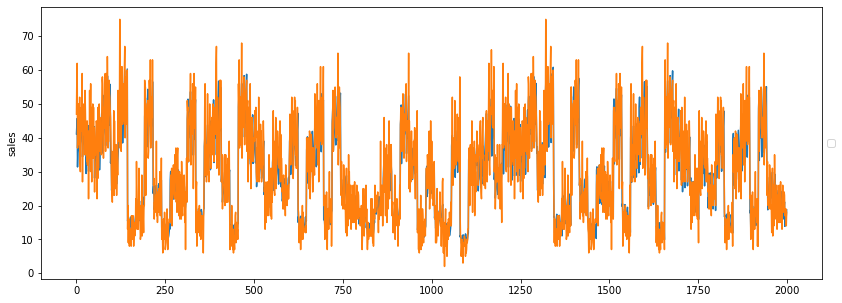

In [161]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_test_all_recons[:2000, 5])
plt.plot(X_test_seq_reshaped[:2000, 5])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


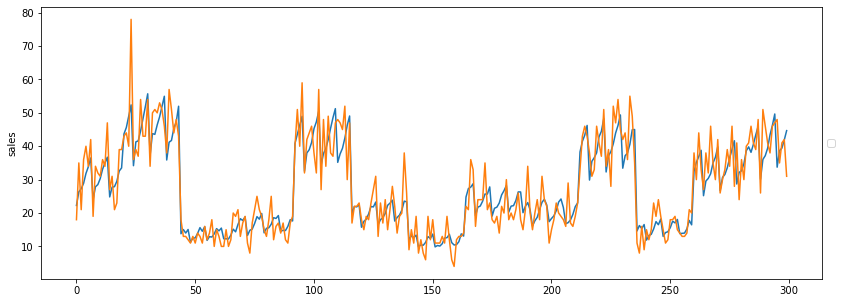

In [162]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_valid_all_recons[100:400, 5])
plt.plot(X_valid_seq_reshaped[100:400, 5])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
from keras import backend as K
from keras.layers import Activation

def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

    
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, ts_sequence_length, num_ts_features, latent_dim=2, intermediate_dim=64, nr_shared=2, name="encoder", activation_func=tf.nn.tanh, activation_dense_func=tf.nn.tanh, **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        #latent_dim = 2

        self.ts_sequence_length = ts_sequence_length
        self.num_ts_features = num_ts_features
        self.inp_seq = keras.Input((self.ts_sequence_length, 10))
        self.inp_lap = keras.Input((10, 10))
        self.inp_feat = keras.Input((10, self.num_ts_features))

        self.encoder_inputs = [self.inp_seq, self.inp_lap, self.inp_feat]
        
        self.gcn_conv1 = GCNConv(32, activation=activation_func)
        
        self.flatten_layer = layers.Flatten()
        
        self.lstm1 = LSTM(32, activation=activation_func, return_sequences=True)
        self.lstm2 = LSTM(16, activation=activation_func)
        
        self.concat_layer = Concatenate()
        self.batch_norm_layer = BatchNormalization()
        
        self.dropout1 = Dropout(0.01)
        self.fully_connected1 = layers.Dense(intermediate_dim, activation=activation_dense_func)
        self.dropout2 = Dropout(0.01)
        
        self.hidden_shared_layer1 = Dense(nr_shared, activation=activation_dense_func)
        self.hidden_unshared_layer1 = Dense(latent_dim-nr_shared, activation=activation_dense_func)

        
    def call(self, inputs):
        self.inp_seq = inputs[0]
        self.inp_feat = inputs[2]
        self.inp_lap = inputs[1]
        
        x = self.gcn_conv1([self.inp_feat, self.inp_lap])
        
        x = self.flatten_layer(x)

        xx = self.lstm1(self.inp_seq)
        xx = self.lstm2(xx)
        
        x = self.concat_layer([x,xx])
        x = self.batch_norm_layer(x)
        x = self.dropout1(x)
        x = self.fully_connected1(x)
        x = self.dropout2(x)
        
        z_shared = self.hidden_shared_layer1(x)
        z_unshared = self.hidden_unshared_layer1(x)
        
        #z = self.dense_mean(x)
        z = tf.concat([z_shared,z_unshared],-1)

        return z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, ts_sequence_length, latent_dim=2, intermediate_dim=64, name="decoder", activation_func=tf.nn.tanh, activation_dense_func=tf.nn.tanh, **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)        
        self.latent_inputs = keras.Input(shape=(nr_ae, latent_dim,))
        
        # split nr_ae into separate tensors
        self.ts_sequence_length=ts_sequence_length
        
        # apply same layers to each split up nr_ae input tensors - use for loop
        self.fully_connected_lstm = layers.Dense(self.ts_sequence_length * 2, activation=activation_dense_func)
        self.reshape_layer_lstm = layers.Reshape((self.ts_sequence_length, 2))
        self.lstm_layer1 = LSTM(10, activation=activation_func, return_sequences=True) # Dense layers in Keras
        
        self.fully_connected_gcn1 = layers.Dense(160, activation=activation_dense_func)
        self.fully_connected_lap1 = layers.Dense(100, activation=activation_dense_func)
        
        self.reshape_layer_gcn = layers.Reshape((10, 16))
        self.reshape_layer_lap = layers.Reshape((10, 10))
        
        # stick nr_ae together
        self.gcn_layer1 = GCNConv(7, activation=activation_func)

    def call(self, inputs):
        x_lstm = self.fully_connected_lstm(inputs)
        x_lstm = self.reshape_layer_lstm(x_lstm)

        x_lstm = self.lstm_layer1(x_lstm)

        x_lap = self.fully_connected_lap1(inputs)
        x_lap = self.reshape_layer_lap(x_lap)
        
        x_gnn = self.fully_connected_gcn1(inputs)
        x_gnn = self.reshape_layer_gcn(x_gnn)
        x_gnn = self.gcn_layer1([x_gnn, x_lap])
        return x_lstm, x_lap, x_gnn

class VAE(keras.Model):
    def __init__(self, 
                 original_dim,
                 ts_sequence_length,
                 num_ts_features,
                 intermediate_dim=64,
                 latent_dim=2,
                 name="variational-autoencoder",
                 activation_func=tf.nn.tanh,
                 activation_dense_func=tf.nn.tanh,
                 **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(ts_sequence_length=ts_sequence_length, num_ts_features=num_ts_features, latent_dim=latent_dim, intermediate_dim=intermediate_dim, activation_func=activation_func, activation_dense_func=activation_dense_func)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim, ts_sequence_length=ts_sequence_length, intermediate_dim=intermediate_dim, activation_func=activation_func, activation_dense_func=activation_dense_func)
        #self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        #self.reconstruction_loss_tracker = keras.metrics.Mean(
        #    name="reconstruction_loss"
        #)
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    #@property
    #def metrics(self):
    #    return [
    #        self.total_loss_tracker,
    #        self.reconstruction_loss_tracker,
    #        self.kl_loss_tracker,
    #    ]

    def call(self, inputs):
        #with tf.GradientTape() as tape:
        z = self.encoder(inputs)
        #print(data[0][0])
        reconstruction = self.decoder(z)
        
        square_diff2 = K.square(z_shared[1:,:]-z_shared[:nr_ae-1,:])
        shared_loss = tf.reduce_mean(square_diff2)
        self.add_loss(shared_loss)

        return reconstruction

In [ ]:
# create a custom callback to print the shared loss and mse reconstruction losses separately in training/val epochs
# create a weighted loss such that we enforce the shared loss as a higher value preferred to the reconstruction.
def get_model():
    vae = VAE(nr_ae, nr_shared, original_dim = 2, latent_dim = 32, ts_sequence_length=sequence_length, num_ts_features=7, activation_func=custom_activation, activation_dense_func=tf.nn.relu)
    vae.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return vae

In [174]:
# Add the parent folder of the current active directory to the system path
# because the root folder is not the active one.
# Ref: https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder

import os
parentdir =os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)

In [177]:
import TIRE.utils
from importlib import reload
reload(TIRE.utils)
import TIRE.utils

In [248]:
window_size = 24
norm_mode = 'timeseries'
timeseries_mode = 'multi'
windows_TD, windows_FD, parameters = TIRE.utils.combine_and_format_mat_datasets('beedance', '../KLCPD/data/beedance/', 
                                                              window_size=window_size, 
                                                              norm_mode = norm_mode, 
                                                              timeseries_mode = timeseries_mode)

In [250]:
windows_TD = np.array(windows_TD)
windows_TD.shape

(3, 4937, 24)

In [251]:
windows_TD = np.array(windows_TD)
windows_TD = np.transpose(windows_TD, (1, 2, 0))

In [209]:
windows_FD = np.array(windows_FD)
windows_FD = np.transpose(windows_FD, (1, 2, 0))

In [252]:
windows_TD = prepare_input_paes(windows_TD, 3)

In [253]:
windows_TD.shape

(4935, 3, 24, 3)

In [211]:
windows_FD = prepare_input_paes(windows_FD, 3)

In [223]:
def get_model():
    vae = VAE(nr_ae=3, nr_shared=16, original_dim = 2, latent_dim = 32, ts_sequence_length=window_size, num_ts_features=windows_TD.shape[3], activation_func=custom_activation, activation_dense_func=tf.nn.relu)
    vae.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return vae

In [224]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

# check why early stopping is not working properly
es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

model_beedance = get_model()
#print(model.summary())
model_beedance.fit([windows_TD], [windows_TD], epochs=100, batch_size=256, 
          validation_data=([windows_TD], [windows_TD]), verbose=2) #, callbacks=[es], verbose=2)


Epoch 1/100
20/20 - 4s - loss: 0.1660 - root_mean_squared_error: 0.4060 - val_loss: 0.1654 - val_root_mean_squared_error: 0.4066 - 4s/epoch - 177ms/step
Epoch 2/100
20/20 - 1s - loss: 0.1639 - root_mean_squared_error: 0.4042 - val_loss: 0.1650 - val_root_mean_squared_error: 0.4061 - 897ms/epoch - 45ms/step
Epoch 3/100
20/20 - 1s - loss: 0.1627 - root_mean_squared_error: 0.4030 - val_loss: 0.1646 - val_root_mean_squared_error: 0.4057 - 880ms/epoch - 44ms/step
Epoch 4/100
20/20 - 1s - loss: 0.1614 - root_mean_squared_error: 0.4015 - val_loss: 0.1641 - val_root_mean_squared_error: 0.4051 - 870ms/epoch - 43ms/step
Epoch 5/100
20/20 - 1s - loss: 0.1599 - root_mean_squared_error: 0.3995 - val_loss: 0.1633 - val_root_mean_squared_error: 0.4042 - 899ms/epoch - 45ms/step
Epoch 6/100
20/20 - 1s - loss: 0.1576 - root_mean_squared_error: 0.3968 - val_loss: 0.1618 - val_root_mean_squared_error: 0.4022 - 883ms/epoch - 44ms/step
Epoch 7/100
20/20 - 1s - loss: 0.1535 - root_mean_squared_error: 0.3914 

ValueError: in user code:

    File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "variational-autoencoder" (type VAE).
    
    in user code:
    
        File "/var/folders/49/gygm7sh12jsdj_70bl_k57xm0000gr/T/ipykernel_20569/827431396.py", line 117, in call  *
            z, z_shared, z_unshared = self.encoder(inputs)
        File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        ValueError: Exception encountered when calling layer "encoder" (type Encoder).
        
        in user code:
        
            File "/var/folders/49/gygm7sh12jsdj_70bl_k57xm0000gr/T/ipykernel_20569/827431396.py", line 46, in call  *
                xx = self.lstm2(self.inp_seq)
            File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/opt/anaconda3/envs/pytorch_geom/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
                raise ValueError(f'Input {input_index} of layer "{layer_name}" is '
        
            ValueError: Input 0 of layer "time_distributed_21" is incompatible with the layer: expected shape=(None, None, 24, 10), found shape=(None, 3, 24, 3)
        
        
        Call arguments received:
          • inputs=('tf.Tensor(shape=(None, 3, 24, 3), dtype=float32)',)
    
    
    Call arguments received:
      • inputs=('tf.Tensor(shape=(None, 3, 24, 3), dtype=float32)',)


In [225]:
pred_valid_all = model_beedance.predict([windows_TD])
pred_test_all = model_beedance.predict([windows_TD])

In [235]:
pred_valid_all_recons = scaler_seq.inverse_transform(pred_valid_all[:, 0, :, :].reshape(-1,10)).reshape(pred_valid_all[:, 0, :, :].shape)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all_recons = scaler_seq.inverse_transform(pred_test_all[:, 0, :, :].reshape(-1,10)).reshape(pred_test_all[:, 0, :, :].shape)
#reverse_test = scaler_seq.inverse_transform(y_test)

In [227]:
pred_test_all_recons.shape

(4935, 24, 3)

In [234]:
windows_TD.shape

(4935, 3, 24, 3)

In [236]:
pred_valid_all_recons = np.resize(pred_valid_all_recons, (np.prod(pred_valid_all_recons.shape[:2]), pred_valid_all_recons.shape[-1]))
pred_valid_all_recons.shape

(118440, 3)

In [237]:
pred_test_all_recons = np.resize(pred_test_all_recons, (np.prod(pred_test_all_recons.shape[:2]), pred_test_all_recons.shape[-1]))
pred_test_all_recons.shape

(118440, 3)

In [238]:
X_valid_seq_reshaped = np.resize(windows_TD, (np.prod(windows_TD[:, 0, :, :].shape[:2]), windows_TD[:, 0, :, :].shape[-1]))
X_valid_seq_reshaped.shape

(118440, 3)

In [239]:
X_test_seq_reshaped = np.resize(windows_TD, (np.prod(windows_TD[:, 0, :, :].shape[:2]), windows_TD[:, 0, :, :].shape[-1]))
X_test_seq_reshaped.shape

(118440, 3)

In [ ]:
error = {}

for store in range(10):
    
    error[store] = np.sqrt(mean_squared_error(reverse_test[:,store], pred_test_all[:,store]))

In [265]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(10), error.values())
plt.xticks(range(10), ['store_'+str(s) for s in range(10)])
plt.ylabel('error')
np.set_printoptions(False)

NameError: name 'error' is not defined

<Figure size 1008x360 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


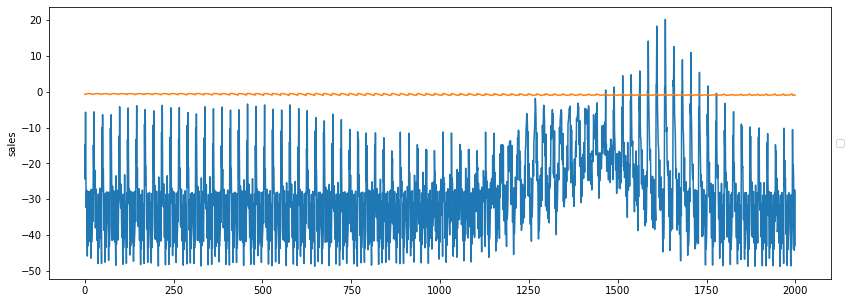

In [254]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_test_all_recons[:2000, 1])
plt.plot(X_test_seq_reshaped[:2000, 1])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


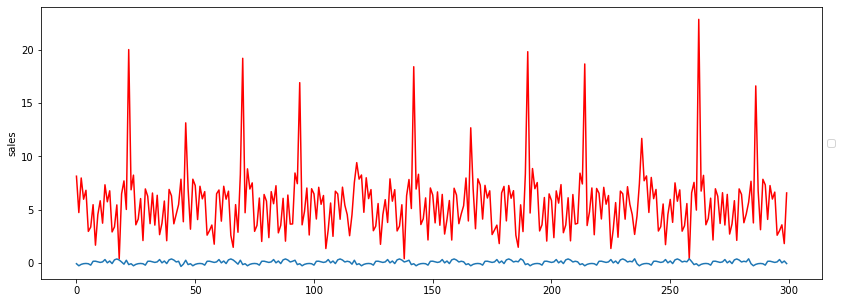

In [246]:
fig = plt.figure(figsize=(14,5))
plt.plot(pred_valid_all_recons[100:400, 2], 'r')
plt.plot(X_valid_seq_reshaped[100:400, 2])

plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))